## Hi!ckathon #5 - Water shortage prediction

This notebook gives you the path to load the train and test datasets of the Hi!ckathon #5. <br>
**<u>Please copy this notebook in the `/shared_storage` folder</u> since you don't read write access to the `/water_shortage_prediction` folder** 

Please fill out your group number and add your group members here: <br>
**Group number**: 56 <br>
**Group members**: Antony , Channdeth , Nadya , Mathieu , Lina , Augustin

In [70]:
import pandas as pd
import numpy as np 
from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from faiss_imputer import FaissImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Paths to the train/test sets
path_train = "~/hfactory_magic_folders/water_shortage_prediction/X_train_Hi5.csv"
path_test = "~/hfactory_magic_folders/water_shortage_prediction/X_test_Hi5.csv"

In [12]:
train = pd.read_csv(path_train, low_memory=False)
test = pd.read_csv(path_test, low_memory=False)

In [13]:
train.head()

,row_index,piezo_station_department_code,piezo_station_update_date,piezo_station_investigation_depth,piezo_station_department_name,piezo_station_commune_code_insee,piezo_station_pe_label,piezo_station_bdlisa_codes,piezo_station_altitude,piezo_station_bss_code,...,prelev_longitude_2,prelev_latitude_2,prelev_commune_code_insee_2,prelev_other_volume_sum,insee_%_agri,insee_pop_commune,insee_med_living_level,insee_%_ind,insee_%_const,piezo_groundwater_level_category
0,0,01,Sun Jul 14 13:00:02 CEST 2024,20.00,Ain,01073,PIEZOMETRE - MARAIS DE LAVOURS (CEYZERIEU - BR...,['712AH37'],232.00,07004X0046/D6-20,...,5.698947,45.725106,1454.0,1.793055e+09,11.8,992.0,25250,2.9,16.2,High
1,1,01,Sun Jul 14 13:00:02 CEST 2024,35.60,Ain,01363,PIEZOMETRE - GRAVIERE (ST-JEAN-LE-VIEUX - BRGM...,['712GB05'],247.25,06754X0077/F1,...,5.464933,46.210734,1051.0,1.085125e+09,0.6,1786.0,24660,44.5,11,Very High
2,2,01,Sun Jul 14 13:00:02 CEST 2024,35.22,Ain,01244,PIEZOMETRE - BORD AUTOROUTE (MEXIMIEUX - BRGM ...,['040AJ43'],218.77,06993X0226/MEXI_2,...,5.085060,45.812828,69266.0,3.810492e+08,0,8085.0,24890,8.4,7.8,High
3,3,01,Sun Jul 14 13:00:02 CEST 2024,34.20,Ain,01288,PIEZOMETRE - GRENY (PERON - BRGM 01) - BSH,"['516AA00', '516AF00']",499.85,06533X0070/F2,...,5.802841,46.366049,39286.0,3.800911e+08,1.5,2838.0,39700,2.4,5.2,Very High
4,4,01,Sun Jul 14 13:00:02 CEST 2024,37.30,Ain,01422,FORAGE - ENCLOS (TOSSIAT - BRGM 01) - BSH,['507AB00'],260.00,06518X0026/P2,...,5.377265,46.080989,1273.0,1.966631e+07,0.2,1352.0,26180,21.5,9.8,Very Low


In [14]:
print("The size of training set: " ,train.shape)

The size of training set:  (2830316, 136)


There are around 3 millions observation and 135 features that could be carefully selected.

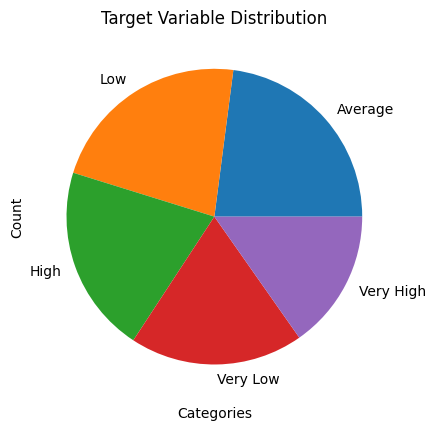

In [17]:
# Plot the distribution of the target variable
train['piezo_groundwater_level_category'].value_counts().plot(kind='pie')
plt.title('Target Variable Distribution')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

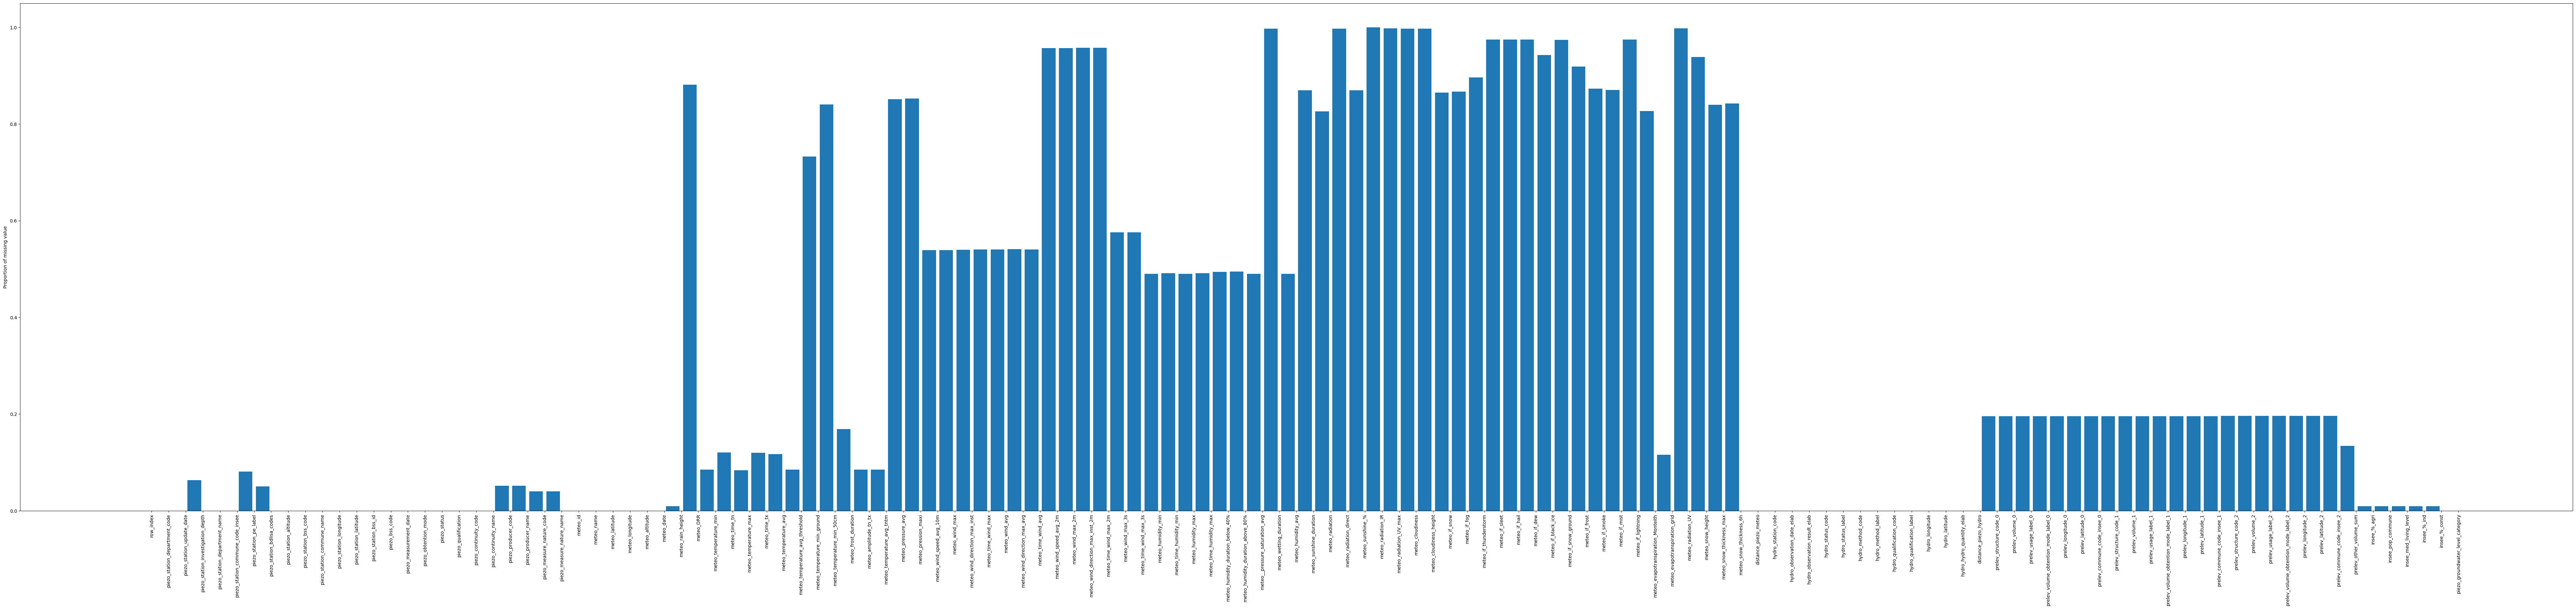

In [19]:
# Visaulize the proportion of missing value
null_counts = train.isnull().sum()/len(train)
plt.figure(figsize=(100,20))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('Proportion of missing value')
plt.bar(np.arange(len(null_counts)),null_counts)
plt.show()

In [23]:
# Check for columns with missing values
train_column_miss = train.isnull().any()
# Calculate the number of columns with missing values
num_missing_columns = train_column_miss.sum()
total_columns = train.shape[1]

print(f'Number of columns with missing values: {num_missing_columns} out of {total_columns}')

Number of columns with missing values: 97 out of 136


In [24]:
def cleaning(
    df: pd.DataFrame,
    piezo: bool = False,
    meteo: bool = False,
    hydro: bool = False,
    prelev: bool = False,
    insee: bool = False
) -> pd.DataFrame:
    """
    Cleans the given DataFrame by excluding specific columns based on the selected categories.

    Parameters:
        df (pd.DataFrame): The input DataFrame to be cleaned.
        piezo (bool): Whether to exclude piezo-related columns.
        meteo (bool): Whether to exclude meteo-related columns.
        hydro (bool): Whether to exclude hydro-related columns.
        prelev (bool): Whether to exclude prelev-related columns.
        insee (bool): Whether to exclude insee-related columns.

    Returns:
        pd.DataFrame: The cleaned DataFrame with the specified columns removed.
    """

    # Define columns to exclude
    excluded_piezo = [
        "piezo_station_latitude", "piezo_station_longitude",
        "piezo_station_department_code", "piezo_station_update_date",
        "piezo_station_department_name", "piezo_station_commune_code_insee",
        "piezo_station_pe_label", "piezo_station_bdlisa_codes",
        "piezo_station_bss_code", "piezo_station_commune_name",
        "piezo_station_bss_id", "piezo_bss_code", "piezo_continuity_name",
        "piezo_producer_code", "piezo_producer_name", "piezo_measure_nature_name"
    ]

    excluded_meteo = [
        "meteo_id", "meteo_radiation_IR", "meteo_name",
        "meteo_temperature_avg_threshold", "meteo_temperature_avg_tntm",
        "meteo_time_tn", "meteo_time_tx", "meteo_if_lightning",
        "meteo_if_smoke", "meteo_if_black_ice", "meteo_wind_direction_max_inst",
        "meteo_wind_direction_max_inst_2m", "meteo_wind_direction_max_avg",
        "meteo_radiation_UV", "meteo_radiation_UV_max", "meteo_altitude",
        "meteo_latitude", "meteo_longitude"
    ]

    excluded_hydro = [
        "hydro_station_code", "hydro_status_label", "hydro_method_code",
        "hydro_method_label", "hydro_qualification_label",
        "hydro_latitude", "hydro_longitude"
    ]

    excluded_prelev = [
        "prelev_structure_code_0", "prelev_commune_code_insee_0",
        "prelev_structure_code_1", "prelev_commune_code_insee_1",
        "prelev_structure_code_2", "prelev_commune_code_insee_2",
        "prelev_other_volume_sum", "prelev_latitude_0", "prelev_longitude_0",
        "prelev_latitude_1", "prelev_longitude_1",
        "prelev_latitude_2", "prelev_longitude_2"
    ]

    excluded_insee = [
        "prelev_commune_code_insee_0", "prelev_commune_code_insee_1",
        "prelev_commune_code_insee_2", "insee_%_agri", "insee_pop_commune",
        "insee_med_living_level", "insee_%_ind", "insee_%_const"
    ]

    columns_to_drop = []
    if piezo:
        columns_to_drop += excluded_piezo
    if meteo:
        columns_to_drop += excluded_meteo
    if hydro:
        columns_to_drop += excluded_hydro
    if prelev:
        columns_to_drop += excluded_prelev
    if insee:
        columns_to_drop += excluded_insee

    df_filtered = df.drop(columns=columns_to_drop, errors="ignore")

    return df_filtered

In [25]:
# Removing redundant columns
df_filtered = cleaning(train, True, True, True, True, True)
# del _train

In [26]:
df_filtered

,row_index,piezo_station_investigation_depth,piezo_station_altitude,piezo_measurement_date,piezo_obtention_mode,piezo_status,piezo_qualification,piezo_continuity_code,piezo_measure_nature_code,meteo_date,...,prelev_volume_0,prelev_usage_label_0,prelev_volume_obtention_mode_label_0,prelev_volume_1,prelev_usage_label_1,prelev_volume_obtention_mode_label_1,prelev_volume_2,prelev_usage_label_2,prelev_volume_obtention_mode_label_2,piezo_groundwater_level_category
0,0,20.00,232.00,2020-01-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2020-01-01,...,1.074315e+10,EAU TURBINEE (barrage),Mesure indirecte,1.060828e+10,EAU TURBINEE (barrage),Mesure indirecte,1.038098e+10,EAU TURBINEE (barrage),Mesure indirecte,High
1,1,35.60,247.25,2020-01-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2020-01-01,...,1.249202e+10,EAU TURBINEE (barrage),Mesure indirecte,2.206200e+09,EAU TURBINEE (barrage),Mesure indirecte,1.818150e+09,EAU TURBINEE (barrage),Mesure indirecte,Very High
2,2,35.22,218.77,2020-01-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2020-01-01,...,1.249202e+10,EAU TURBINEE (barrage),Mesure indirecte,1.572484e+09,ENERGIE,Mesure indirecte,6.981240e+08,EAU TURBINEE (barrage),Mesure indirecte,High
3,3,34.20,499.85,2020-01-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2020-01-01,...,1.038289e+10,EAU TURBINEE (barrage),Mesure indirecte,3.667774e+09,EAU TURBINEE (barrage),Mesure indirecte,1.843691e+08,EAU TURBINEE (barrage),Mesure indirecte,Very High
4,4,37.30,260.00,2020-01-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2020-01-01,...,2.206200e+09,EAU TURBINEE (barrage),Mesure indirecte,1.818150e+09,EAU TURBINEE (barrage),Mesure indirecte,9.263080e+08,EAU TURBINEE (barrage),Mesure indirecte,Very Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830311,3294080,24.00,63.00,2023-05-31,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2023-05-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very Low
2830312,3294081,25.50,103.00,2023-05-31,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2023-05-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very Low
2830313,3294082,30.00,83.00,2023-05-31,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2023-05-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
2830314,3294083,630.00,24.00,2023-05-31,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2023-05-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High


In [27]:
# Unifies longitude and latitude columns
def unify_long_lat(df: pd.DataFrame, distance_threshold: int = 25) -> pd.DataFrame:
    """
    Unifies longitude and latitude into single columns if distance_piezo_hydro is below the threshold.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        distance_threshold (int): The maximum distance for unification.

    Returns:
        pd.DataFrame: The modified DataFrame with unified longitude and latitude columns.
    """
    # Columns to exclude after processing
    excluding = [
        "piezo_station_latitude",
        "piezo_station_longitude",
        "hydro_longitude",
        "hydro_latitude",
        "meteo_longitude",
        "meteo_latitude",
        "distance_piezo_hydro",
        "distance_hydro_meteo",
    ]

    # Ensure the required column exists
    if "distance_piezo_hydro" in df.columns:
        # Create unified longitude and latitude where condition is met
        df.loc[df["distance_piezo_hydro"] < distance_threshold, "longitude"] = df[
            "piezo_station_longitude"
        ]
        df.loc[df["distance_piezo_hydro"] < distance_threshold, "latitude"] = df[
            "piezo_station_latitude"
        ]

    # Drop the excluded columns
    df = df.drop(columns=excluding, errors="ignore")

    return df

In [28]:
# Unify and split the date into day, Month, year
def unify_and_split_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Unifies date columns into a single column and extracts year, month, and day components.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.

    Returns:
        pd.DataFrame: The modified DataFrame with unified date and extracted year, month, and day columns.
    """
    # Columns to exclude after processing
    excluding = ["piezo_measurement_date", "meteo_date", "hydro_observation_date_elab"]

    # Check and assign the first available date column
    if "piezo_measurement_date" in df.columns:
        df["date"] = df["piezo_measurement_date"]

    # Drop original date columns
    df = df.drop(columns=excluding, errors="ignore")

    # Ensure 'date' is in datetime format
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Extract year, month, and day components
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    # df["day_of_week"] = df["date"].dt.dayofweek  # Optional: Include day of the week

    # Drop the date
    df = df.drop(columns=["date"], errors="ignore")

    return df

In [29]:
df_unify = unify_and_split_date(df_filtered)
df_unify.head()
del df_filtered

In [ ]:
# Select the colomn base on the ratio of missing value over the dataset
def keep_essential_data(df: pd.DataFrame, threshold: float) -> pd.DataFrame:
    """
    Keeps essential data by removing columns with less than the threshold % of non-null values.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        threshold (float): Minimum percentage (as a fraction) of non-null values required to keep a column.

    Returns:
        pd.DataFrame: Filtered DataFrame containing only columns that meet the threshold.
        list: List of columns removed due to having less than the threshold % of non-null values.
    """

    # Compute the percentage of non-null values for each column
    non_null_percentage = df.notnull().mean()

    # Identify columns to keep and remove based on the threshold
    columns_to_keep = non_null_percentage[non_null_percentage >= threshold].index
    columns_removed = non_null_percentage[non_null_percentage < threshold].index

    filtered_df = df[columns_to_keep]

    print("Initial columns:", df.columns.tolist())
    print("Kept columns:", filtered_df.columns.tolist())
    print("Removed columns:", list(columns_removed))

    return filtered_df, list(columns_removed)

In [32]:
essential_df, cols_to_remove = keep_essential_data(df_unify, threshold=0.8)

Initial columns: ['row_index', 'piezo_station_investigation_depth', 'piezo_station_altitude', 'piezo_obtention_mode', 'piezo_status', 'piezo_qualification', 'piezo_continuity_code', 'piezo_measure_nature_code', 'meteo_rain_height', 'meteo_DRR', 'meteo_temperature_min', 'meteo_temperature_max', 'meteo_temperature_avg', 'meteo_temperature_min_ground', 'meteo_temperature_min_50cm', 'meteo_frost_duration', 'meteo_amplitude_tn_tx', 'meteo_pressure_avg', 'meteo_pression_maxi', 'meteo_wind_speed_avg_10m', 'meteo_wind_max', 'meteo_time_wind_max', 'meteo_wind_avg', 'meteo_time_wind_avg', 'meteo_wind_speed_avg_2m', 'meteo_wind_max_2m', 'meteo_time_wind_max_2m', 'meteo_wind_max_3s', 'meteo_time_wind_max_3s', 'meteo_humidity_min', 'meteo_time_humidity_min', 'meteo_humidity_max', 'meteo_time_humidity_max', 'meteo_humidity_duration_below_40%', 'meteo_humidity_duration_above_80%', 'meteo__pressure_saturation_avg', 'meteo_wetting_duration', 'meteo_humidity_avg', 'meteo_sunshine_duration', 'meteo_radia

In [33]:
essential_df

,row_index,piezo_station_investigation_depth,piezo_station_altitude,piezo_obtention_mode,piezo_status,piezo_qualification,piezo_continuity_code,piezo_measure_nature_code,meteo_rain_height,meteo_temperature_min,...,prelev_volume_1,prelev_usage_label_1,prelev_volume_obtention_mode_label_1,prelev_volume_2,prelev_usage_label_2,prelev_volume_obtention_mode_label_2,piezo_groundwater_level_category,year,month,day
0,0,20.00,232.00,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.2,-1.6,...,1.060828e+10,EAU TURBINEE (barrage),Mesure indirecte,1.038098e+10,EAU TURBINEE (barrage),Mesure indirecte,High,2020,1,1
1,1,35.60,247.25,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.0,-2.2,...,2.206200e+09,EAU TURBINEE (barrage),Mesure indirecte,1.818150e+09,EAU TURBINEE (barrage),Mesure indirecte,Very High,2020,1,1
2,2,35.22,218.77,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,NaN,-1.4,...,1.572484e+09,ENERGIE,Mesure indirecte,6.981240e+08,EAU TURBINEE (barrage),Mesure indirecte,High,2020,1,1
3,3,34.20,499.85,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.0,-2.3,...,3.667774e+09,EAU TURBINEE (barrage),Mesure indirecte,1.843691e+08,EAU TURBINEE (barrage),Mesure indirecte,Very High,2020,1,1
4,4,37.30,260.00,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.0,-2.1,...,1.818150e+09,EAU TURBINEE (barrage),Mesure indirecte,9.263080e+08,EAU TURBINEE (barrage),Mesure indirecte,Very Low,2020,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830311,3294080,24.00,63.00,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Very Low,2023,5,31
2830312,3294081,25.50,103.00,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Very Low,2023,5,31
2830313,3294082,30.00,83.00,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Low,2023,5,31
2830314,3294083,630.00,24.00,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.0,9.9,...,NaN,NaN,NaN,NaN,NaN,NaN,High,2023,5,31


Variable: piezo_station_altitude
count    2.830316e+06
mean     1.469380e+02
std      1.924840e+02
min     -9.990000e+02
25%      4.100000e+01
50%      1.070700e+02
75%      1.860000e+02
max      2.150000e+03
Name: piezo_station_altitude, dtype: float64


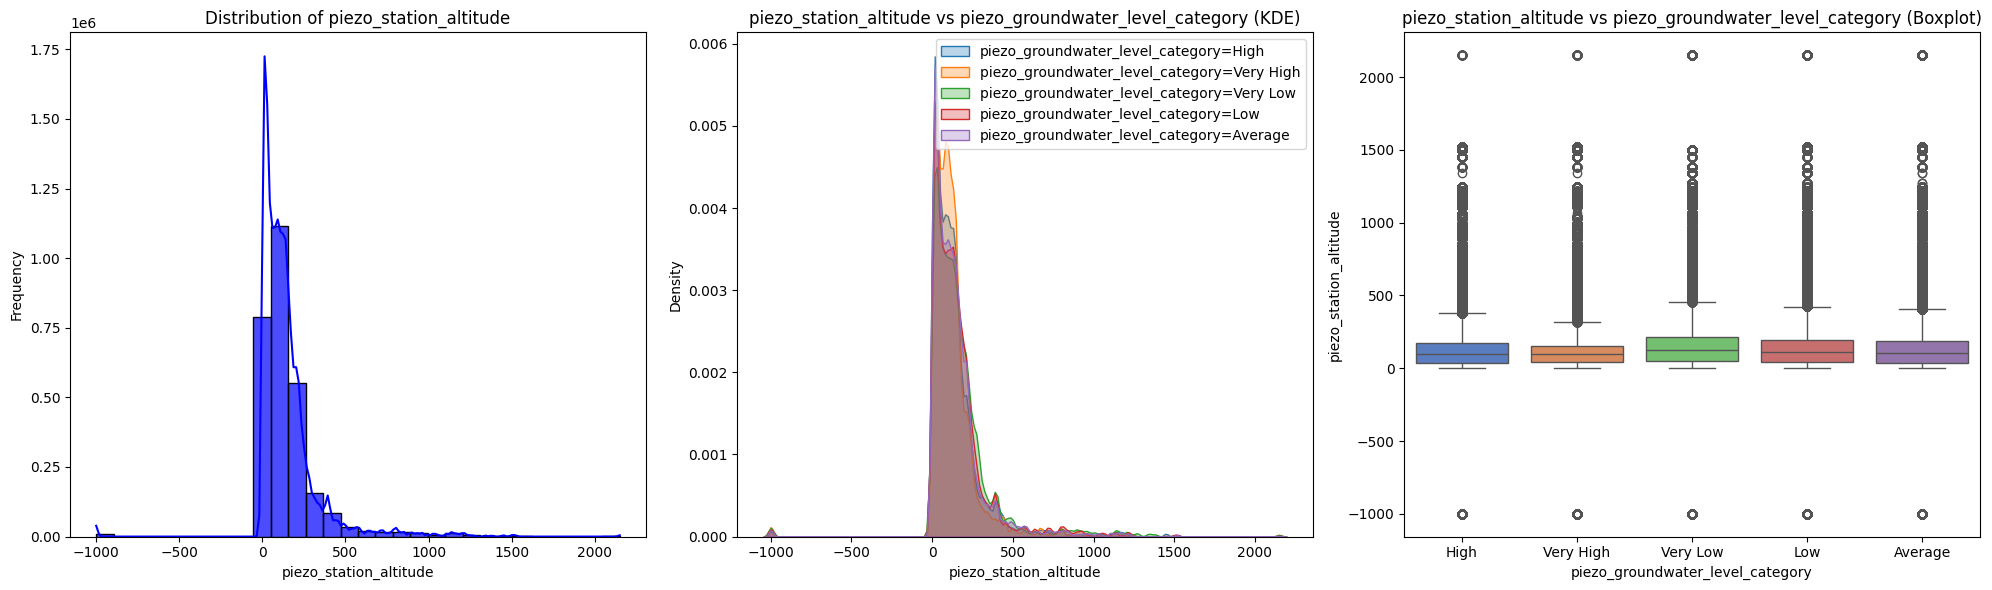

Variable: piezo_continuity_code
count    2.830316e+06
mean     1.999084e+00
std      3.024831e-02
min      1.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: piezo_continuity_code, dtype: float64


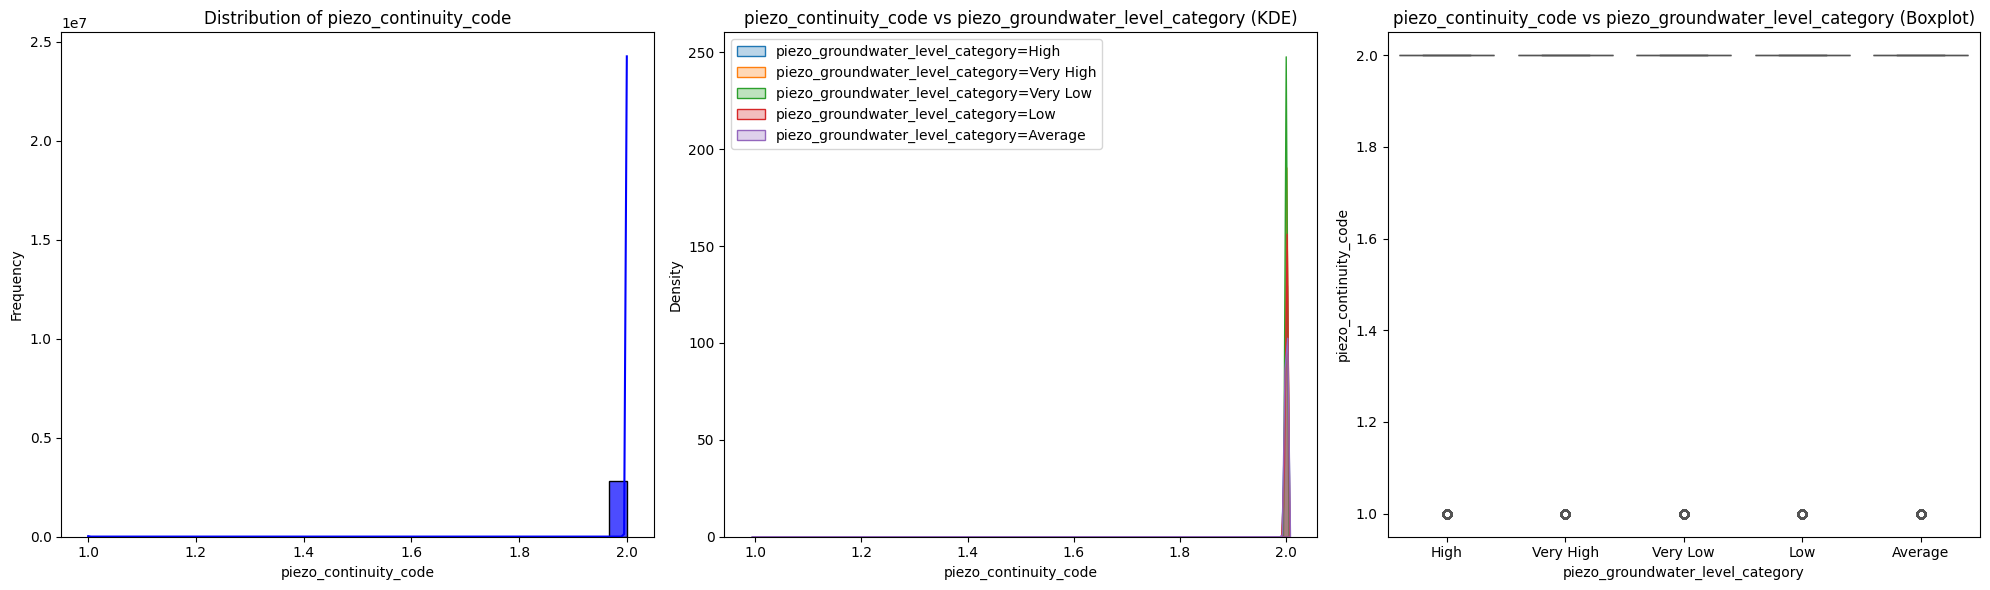

Variable: meteo_rain_height
count    2.804839e+06
mean     2.071651e+00
std      5.191582e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e-01
75%      1.600000e+00
max      2.480000e+02
Name: meteo_rain_height, dtype: float64


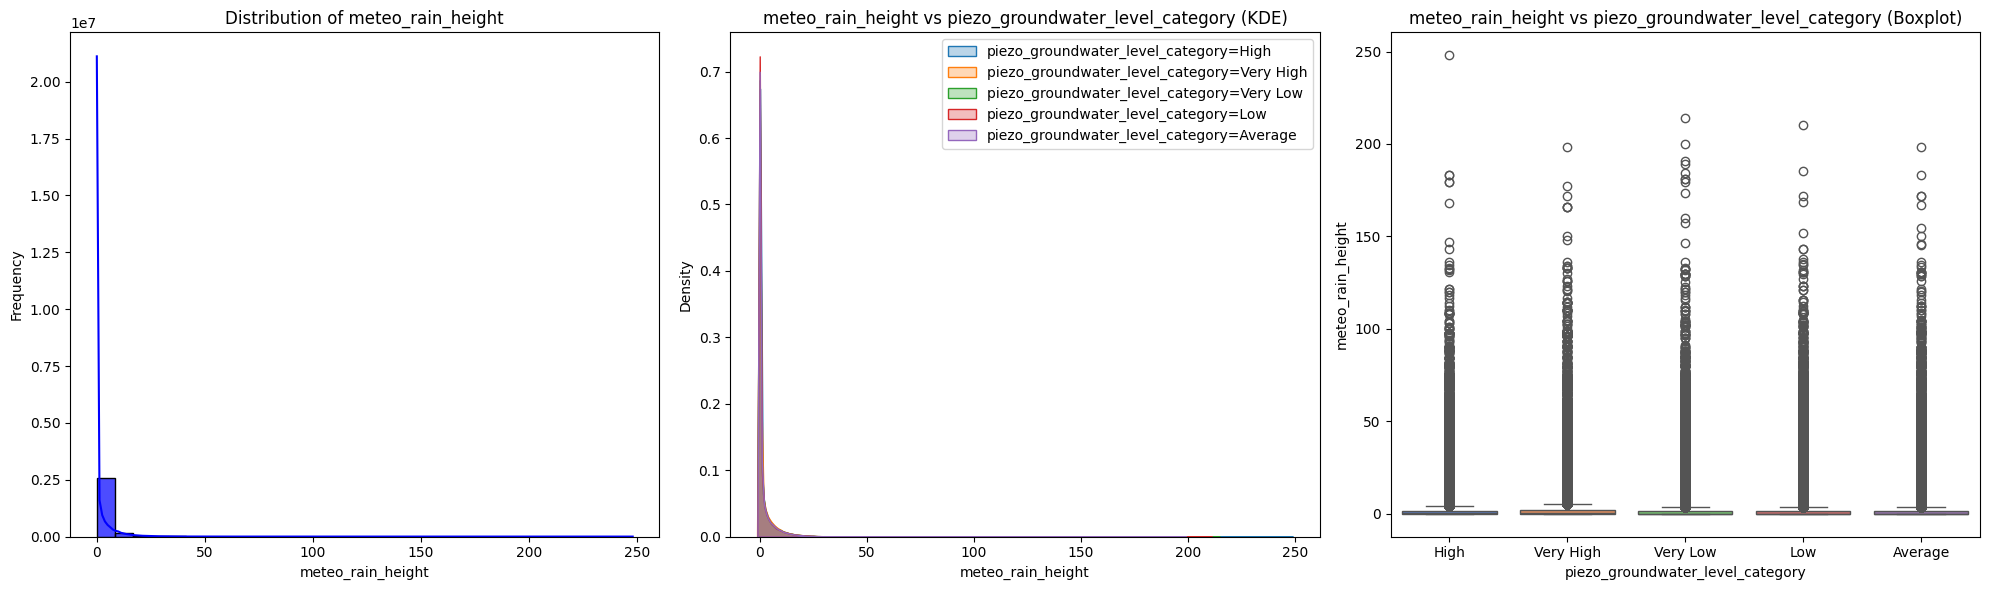

In [38]:
# Plot and detect the outlier of numerical feature
nb_var_interest = 5
numerical_cols = essential_df.select_dtypes(include=['number']).columns
target_var = 'piezo_groundwater_level_category'

for i, varc in enumerate(numerical_cols[2:nb_var_interest]): 
    print(f"Variable: {varc}")
    print(essential_df[varc].describe()) 

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    sns.histplot(essential_df[varc], bins=30, kde=True, color='blue', alpha=0.7)
    plt.title(f"Distribution of {varc}")
    plt.xlabel(varc)
    plt.ylabel("Frequency")

    plt.subplot(1, 3, 2)
    for category in essential_df[target_var].unique():
        subset = essential_df[essential_df[target_var] == category]
        sns.kdeplot(
            subset[varc],
            label=f"{target_var}={category}",
            fill=True,
            alpha=0.3
        )
    plt.title(f"{varc} vs {target_var} (KDE)")
    plt.xlabel(varc)
    plt.ylabel("Density")
    plt.legend()

    # Boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(x=target_var, y=varc, data=essential_df, hue=target_var, palette='muted', dodge=False)
    plt.title(f"{varc} vs {target_var} (Boxplot)")
    plt.xlabel(target_var)
    plt.ylabel(varc)

    plt.tight_layout()
    plt.show()

In [39]:
def detect_outliers(df, columns):
    """
    Detects columns with outliers using the IQR method.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of columns to check for outliers.

    Returns:
        list: Columns with detected outliers.
    """
    columns_with_outliers = []

    for col in columns:
        # Calculate IQR bounds
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Check for outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if len(outliers) > 0:
            columns_with_outliers.append(col)

    return columns_with_outliers


def handle_outliers(
    df, columns, method="cap", lower_quantile=0.05, upper_quantile=0.95
):
    """
    Handles outliers in the specified columns of a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): Columns to handle outliers in.
        method (str): Method to handle outliers - "remove", "cap", "replace", "log".
        lower_quantile (float): Lower quantile for capping (used if method="cap").
        upper_quantile (float): Upper quantile for capping (used if method="cap").

    Returns:
        pd.DataFrame: The DataFrame with outliers handled.
    """
    for col in columns:
        # Skip columns with constant values
        if df[col].nunique() <= 1:
            print(f"Skipping column {col} (constant values)")
            continue

        # Calculate IQR bounds
        Q1 = df[col].dropna().quantile(0.25)
        Q3 = df[col].dropna().quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        print(f"Processing column: {col}")

        if method == "remove":
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        elif method == "cap":
            lower = df[col].dropna().quantile(lower_quantile)
            upper = df[col].dropna().quantile(upper_quantile)
            df.loc[:, col] = df[col].clip(lower=lower, upper=upper)
        elif method == "replace":
            median = df[col].median()
            df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = median
        elif method == "log":
            df.loc[:, col] = np.log1p(df[col])

    return df

# Detect and handle outliers
numerical_columns = essential_df.select_dtypes(include=["float64", "int64"]).columns
columns_with_outliers = detect_outliers(essential_df, numerical_columns)

print("Columns with outliers:", columns_with_outliers)

Columns with outliers: ['piezo_station_investigation_depth', 'piezo_station_altitude', 'piezo_continuity_code', 'meteo_rain_height', 'meteo_temperature_min', 'meteo_temperature_max', 'meteo_temperature_avg', 'meteo_frost_duration', 'meteo_amplitude_tn_tx', 'meteo_evapotranspiration_grid', 'distance_piezo_meteo', 'hydro_observation_result_elab', 'hydro_status_code', 'distance_piezo_hydro', 'prelev_volume_0', 'prelev_volume_1', 'prelev_volume_2']


In [40]:
# new pandas dataset after detecting outlier
essential_df = handle_outliers(
    essential_df,
    columns_with_outliers,
    method="cap",
    lower_quantile=0.05,
    upper_quantile=0.95,
)

Processing column: piezo_station_investigation_depth
Processing column: piezo_station_altitude
Processing column: piezo_continuity_code
Processing column: meteo_rain_height
Processing column: meteo_temperature_min
Processing column: meteo_temperature_max
Processing column: meteo_temperature_avg
Processing column: meteo_frost_duration
Processing column: meteo_amplitude_tn_tx
Processing column: meteo_evapotranspiration_grid
Processing column: distance_piezo_meteo
Processing column: hydro_observation_result_elab
Processing column: hydro_status_code
Processing column: distance_piezo_hydro
Processing column: prelev_volume_0
Processing column: prelev_volume_1
Processing column: prelev_volume_2


In [51]:
# Replacing the missing value method
def impute_na(df: pd.DataFrame, strategy: str = "mean", method: str = "simple", **kwargs) -> pd.DataFrame:
    """
    Impute missing values in a DataFrame for both numerical and categorical columns.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame with missing values.
    strategy : str, optional
        The imputation strategy for numerical columns (default is "mean").
        Options depend on the `method`:
        - For "simple": "mean", "median", or "most_frequent".
        - For "knn" and "faiss": Strategy is ignored.
    method : str, optional
        The imputation method to use for numerical columns (default is "simple").
        - "simple": Uses SimpleImputer.
        - "knn": Uses KNNImputer.
        - "faiss": Uses FaissImputer.
    **kwargs
        Additional keyword arguments passed to the chosen imputation method.

    Returns
    -------
    pd.DataFrame
        The DataFrame with missing values imputed.
    """
    # Separate numerical and categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'datetime64']).columns
    numerical_cols = df.select_dtypes(include=['number']).columns

    df_copy = df.copy()

    # Choose the imputer for numerical columns
    if method == "simple":
        imputer = SimpleImputer(strategy=strategy, **kwargs)
    elif method == "knn":
        imputer = KNNImputer(**kwargs)
    elif method == "faiss":
        try:
            imputer = FaissImputer(**kwargs)
        except ImportError as e:
            raise ImportError("FaissImputer is not installed. Install it to use this method.") from e
    else:
        raise ValueError(f"Unsupported method: {method}. Choose 'simple', 'knn', or 'faiss'.")

    # Impute numerical columns
    df_copy[numerical_cols] = pd.DataFrame(
        imputer.fit_transform(df_copy[numerical_cols]),
        columns=numerical_cols,
        index=df_copy.index
    )

    # Impute categorical columns using the mode
    for col in categorical_cols:
        if df_copy[col].isnull().any():
            mode_value = df_copy[col].mode()[0]  # Get mode, modify
            df_copy[col] = df_copy[col].fillna(mode_value) 
    print("number of missing value", df_copy.isnull().sum().sum()) 
    return df_copy

In [52]:
df_imputed = impute_na(essential_df, strategy="mean")

number of missing value 0


In [53]:
df_imputed

,row_index,piezo_station_investigation_depth,piezo_station_altitude,piezo_obtention_mode,piezo_status,piezo_qualification,piezo_continuity_code,piezo_measure_nature_code,meteo_rain_height,meteo_temperature_min,...,prelev_volume_1,prelev_usage_label_1,prelev_volume_obtention_mode_label_1,prelev_volume_2,prelev_usage_label_2,prelev_volume_obtention_mode_label_2,piezo_groundwater_level_category,year,month,day
0,0.0,20.00,232.00,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.200000,-1.600000,...,1.021397e+09,EAU TURBINEE (barrage),Mesure indirecte,3.425333e+08,EAU TURBINEE (barrage),Mesure indirecte,High,2020.0,1.0,1.0
1,1.0,35.60,247.25,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.000000,-2.200000,...,1.021397e+09,EAU TURBINEE (barrage),Mesure indirecte,3.425333e+08,EAU TURBINEE (barrage),Mesure indirecte,Very High,2020.0,1.0,1.0
2,2.0,35.22,218.77,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,1.654742,-1.400000,...,1.021397e+09,ENERGIE,Mesure indirecte,3.425333e+08,EAU TURBINEE (barrage),Mesure indirecte,High,2020.0,1.0,1.0
3,3.0,34.20,445.76,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.000000,-2.200000,...,1.021397e+09,EAU TURBINEE (barrage),Mesure indirecte,1.843691e+08,EAU TURBINEE (barrage),Mesure indirecte,Very High,2020.0,1.0,1.0
4,4.0,37.30,260.00,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.000000,-2.100000,...,1.021397e+09,EAU TURBINEE (barrage),Mesure indirecte,3.425333e+08,EAU TURBINEE (barrage),Mesure indirecte,Very Low,2020.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830311,3294080.0,24.00,63.00,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.000000,7.276486,...,9.083969e+07,EAU POTABLE,Mesure directe,3.474951e+07,EAU POTABLE,Mesure directe,Very Low,2023.0,5.0,31.0
2830312,3294081.0,25.50,103.00,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.000000,7.276486,...,9.083969e+07,EAU POTABLE,Mesure directe,3.474951e+07,EAU POTABLE,Mesure directe,Very Low,2023.0,5.0,31.0
2830313,3294082.0,30.00,83.00,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.000000,7.276486,...,9.083969e+07,EAU POTABLE,Mesure directe,3.474951e+07,EAU POTABLE,Mesure directe,Low,2023.0,5.0,31.0
2830314,3294083.0,276.00,24.00,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,0.000000,9.900000,...,9.083969e+07,EAU POTABLE,Mesure directe,3.474951e+07,EAU POTABLE,Mesure directe,High,2023.0,5.0,31.0


In [56]:
# Pre-process the data both training_set and test_set(for submitting)
target_mapping = {
    "Very Low": 0,
    "Low": 1,
    "Average": 2,
    "High": 3,
    "Very High": 4
}

y_mapped = df_imputed["piezo_groundwater_level_category"].map(target_mapping)

X = df_imputed.drop(columns=["piezo_groundwater_level_category", "row_index"])
y = y_mapped

# Preprocess features (numerical scaling, categorical encoding)
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)
preprocessor.fit(X) #Keep this for test data
X_transformed = preprocessor.transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [62]:
#In case need to transfor the date to sin and cos
def transform_circular(df):

    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    df = df.drop(columns=["day", "month"])
    
    return df

In [63]:
# For test data (submiting)
df_test_cleaned = cleaning(test, True, True, True, True, True)
df_test_new = df_test_cleaned.drop(columns=cols_to_remove, errors="ignore")
df_test_new = df_test_cleaned.drop(columns="row_index", errors="ignore")
df_test_new = impute_na(df_test_new)

number of missing value 0


In [64]:
df_test_new

,piezo_station_investigation_depth,piezo_station_altitude,piezo_measurement_date,piezo_obtention_mode,piezo_status,piezo_qualification,piezo_continuity_code,piezo_measure_nature_code,meteo_date,meteo_rain_height,...,distance_piezo_hydro,prelev_volume_0,prelev_usage_label_0,prelev_volume_obtention_mode_label_0,prelev_volume_1,prelev_usage_label_1,prelev_volume_obtention_mode_label_1,prelev_volume_2,prelev_usage_label_2,prelev_volume_obtention_mode_label_2
0,20.00,232.00,2022-06-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2022-06-01,7.400000,...,7.093852,3.962999e+08,EAU POTABLE,Mesure directe,7.985101e+07,EAU POTABLE,Mesure directe,1.501822e+07,EAU POTABLE,Mesure directe
1,35.60,247.25,2022-06-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2022-06-01,3.400000,...,2.624373,3.962999e+08,EAU POTABLE,Mesure directe,7.985101e+07,EAU POTABLE,Mesure directe,1.501822e+07,EAU POTABLE,Mesure directe
2,35.22,218.77,2022-06-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2022-06-01,1.836326,...,1.542071,3.962999e+08,EAU POTABLE,Mesure directe,7.985101e+07,EAU POTABLE,Mesure directe,1.501822e+07,EAU POTABLE,Mesure directe
3,34.20,499.85,2022-06-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2022-06-01,12.800000,...,7.163470,3.962999e+08,EAU POTABLE,Mesure directe,7.985101e+07,EAU POTABLE,Mesure directe,1.501822e+07,EAU POTABLE,Mesure directe
4,37.30,260.00,2022-06-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2022-06-01,2.200000,...,1.528669,3.962999e+08,EAU POTABLE,Mesure directe,7.985101e+07,EAU POTABLE,Mesure directe,1.501822e+07,EAU POTABLE,Mesure directe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611203,24.00,63.00,2023-09-30,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2023-09-30,0.000000,...,5.424903,3.962999e+08,EAU POTABLE,Mesure directe,7.985101e+07,EAU POTABLE,Mesure directe,1.501822e+07,EAU POTABLE,Mesure directe
611204,25.50,103.00,2023-09-30,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2023-09-30,0.000000,...,15.409259,3.962999e+08,EAU POTABLE,Mesure directe,7.985101e+07,EAU POTABLE,Mesure directe,1.501822e+07,EAU POTABLE,Mesure directe
611205,30.00,83.00,2023-09-30,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2023-09-30,0.000000,...,17.738903,3.962999e+08,EAU POTABLE,Mesure directe,7.985101e+07,EAU POTABLE,Mesure directe,1.501822e+07,EAU POTABLE,Mesure directe
611206,630.00,24.00,2023-09-30,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,N,2023-09-30,0.200000,...,3.593867,3.962999e+08,EAU POTABLE,Mesure directe,7.985101e+07,EAU POTABLE,Mesure directe,1.501822e+07,EAU POTABLE,Mesure directe


In [65]:
# Preprocess features (numerical scaling, categorical encoding) test
numerical_cols = df_test_new.select_dtypes(include=['number']).columns
categorical_cols = df_test_new.select_dtypes(include=['object']).columns

X_test_submit = preprocessor.transform(X)

In [66]:
X_test_submit.shape[1] == X_test.shape[1]

True

# Modelisation 

In [68]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_transformed, y)
print("Baseline Accuracy (Most Frequent):", dummy.score(X_test, y_test))

Baseline Accuracy (Most Frequent): 0.22957121456231097


In [ ]:
# Random forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Random Forest")
print('Accuracy: ',accuracy_rf)